#**Introduction**

The availability of large-scale open crime data has enabled more detailed analysis of crime patterns across the UK; however, the volume and complexity of such data require scalable processing techniques. The UK Home Office Street Level Crime dataset contains millions of geolocated records, making distributed data processing frameworks such as Apache Spark essential for efficient analysis. These technologies enable large datasets to be filtered, aggregated, and integrated in ways not feasible using traditional single-machine approaches (Dean & Ghemawat, 2008).

This project evaluates three claims relating to UK crime patterns: that burglary crime is continuously increasing, that Liverpool experiences more firearm incidents per head than any other area in the UK, and that firearm-related crimes are closely associated with drug offences. The aim is to assess these claims empirically using transparent, data-driven methods, with findings interpreted from the perspective of an insurance company concerned with crime-related risk and regional variation (Eck et al., 2005).

To achieve this, a scalable analytics pipeline is implemented using Apache Spark on a cloud Infrastructure as a Service (IaaS) platform. The crime dataset is filtered to relevant offence categories and combined with population data to enable per-capita comparisons. Temporal trend analysis, regional comparison, correlation-based statistical techniques, and selected visualisations are used to evaluate the claims, while methodological assumptions and limitations are critically considered.



# **Importing Libraries:**


In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

# **Initialising Spark Session:**


In [2]:
#initialise Spark Session
spark = SparkSession\
	.builder\
	.appName("KF7032 Assignment")\
	.config("spark.some.config.option", "some-value")\
	.getOrCreate()
spark

# **Data Loading:**


In [3]:
# Create a dataframe to read the files
DF = spark.read.csv('Sample_1pc_Data.csv.gz', header=True, inferSchema=True)
LSOA_pop = spark.read.csv("LSOA_pop_v2.csv", header=True, inferSchema=True)

In [4]:
print("Total crime records:", DF.count())

Total crime records: 651301


# **Filtering Relevant Crimes:**


In [5]:
# Filter the relevent crime type
Crimes  = ["Burglary", "Possession of weapons", "Drugs"]
Filtered_Crimes = (DF.dropna(subset=["Crime type"]))
Filtered_Crimes = (Filtered_Crimes.filter(col("Crime type").isin(Crimes)))

# Diagnostics: show counts
Filtered_Crimes.groupBy("Crime type").count().show()

+--------------------+-----+
|          Crime type|count|
+--------------------+-----+
|               Drugs|16914|
|            Burglary|43382|
|Possession of wea...| 2758|
+--------------------+-----+



# **Burglary Trend Analysis:**


In [6]:
# I decided to group by year instead of Month for better visualization
Burglary_Crime = Filtered_Crimes.withColumn("Year", substring(col("Month"), 1, 4))
Burglary_trend = Burglary_Crime.filter(col("Crime type") == "Burglary") \
.groupBy("Year") \
.count() \
.orderBy("Year")

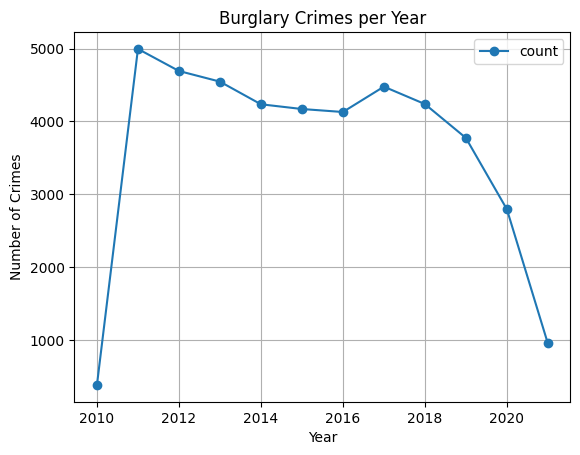

In [7]:
# Buglary trend line chart
burglary_plot = Burglary_trend.toPandas()
burglary_plot.plot(x='Year', y='count', kind='line', marker='o')
plt.title("Burglary Crimes per Year")
plt.ylabel("Number of Crimes")
plt.grid(True)
plt.show()

**Conclusion:** Overall trend is decreasing after the peak in 2011. So the claim that “Burglary crime is continuously increasing” is false.

# **Firearms Incidents Assumptions:**


In [8]:
# Firearms Assumptions
Firearms_Incident = (DF.dropna(subset=["Crime type", "LSOA name", "Last outcome category"])
                    .filter(col("Crime type") == "Possession of weapons")
                    .filter(col("Last outcome category") == "Offender sent to prison")
)

# **Firearms Incidents per Head:**


In [9]:
# Firearms incedent by LASOA name
Firearms_by_LSOA_name = (
                    Firearms_Incident
                    .groupBy("LSOA name")
                    .count()
                    .withColumnRenamed("count", "Firearms_Incident")
)

In [10]:
# Join the LSOA name with the LSOA population
Firearms_with_pop = Firearms_by_LSOA_name.join(LSOA_pop, Firearms_by_LSOA_name["LSOA name"] == LSOA_pop["geography"], \
                                               how="inner")

In [11]:
# Firearms incidents per head
Firearms_with_pop = Firearms_with_pop.withColumn(
    "Incidents_per_head", col("Firearms_Incident") / col("Variable: All usual residents; measures: Value"))

In [12]:
# Liverpool Firearms incidents per head
liverpool_Firearms = Firearms_with_pop.filter(col("LSOA name").like("%Liverpool%")) \
.select("LSOA name", "Firearms_Incident", "Variable: All usual residents; measures: Value", "Incidents_per_head")

In [13]:
# Rename population column for readability and display Liverpool firearms table
liverpool_Firearms = liverpool_Firearms.withColumnRenamed(
    "Variable: All usual residents; measures: Value", "Population"
)
liverpool_Firearms.show(truncate=False)

+--------------+-----------------+----------+---------------------+
|LSOA name     |Firearms_Incident|Population|Incidents_per_head   |
+--------------+-----------------+----------+---------------------+
|Liverpool 028C|1                |1821      |5.491488193300384E-4 |
|Liverpool 031F|1                |2572      |3.8880248833592535E-4|
|Liverpool 032B|1                |1354      |7.385524372230429E-4 |
|Liverpool 058D|1                |2175      |4.597701149425287E-4 |
+--------------+-----------------+----------+---------------------+



# **Comparison between Liverpool and Anywhere else in the UK:**


In [14]:
# Comparison beetween Firearms in Liverpool per head and anywhere in the UK
liverpool = Firearms_with_pop.filter(col("LSOA name").like("%Liverpool%"))
Anywhere_in_UK = Firearms_with_pop.filter(~col("LSOA name").like("%Liverpool%"))

In [15]:
liverpool_max_firearm = liverpool.agg({"Incidents_per_head": "max"}).collect()[0][0]
print(f"Maximum firearm incidents per head in Liverpool: {liverpool_max_firearm}")

Maximum firearm incidents per head in Liverpool: 0.0007385524372230429


In [16]:
Anywhere_in_UK_max = Anywhere_in_UK.agg({"Incidents_per_head": "max"}).collect()[0][0]
print(f"Max incidents per head in rest of the UK: {Anywhere_in_UK_max}")

Max incidents per head in rest of the UK: 0.0010121457489878543


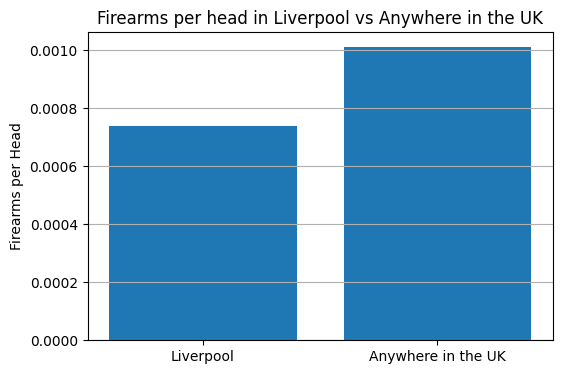

In [17]:
# Comprison bar chart
labels = ["Liverpool", "Anywhere in the UK"]
values = [liverpool_max_firearm, Anywhere_in_UK_max]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.title("Firearms per head in Liverpool vs Anywhere in the UK")
plt.ylabel("Firearms per Head")
plt.grid(axis="y")
plt.show()

**Conclusion:** The claim that Liverpool has more firearms incidents per head than anywhere else in the UK is false. Although firearms offences occur in Liverpool, its highest per-capita rate (0.007) is lower than the maximum observed elsewhere in the UK (0.02), indicating higher relative firearm incidence in other areas once population size is considered.

# **Firearms and Drugs Association:**


In [18]:
# Firearms and Drugs
Firearms = Filtered_Crimes.filter(col("Crime type") == "Possession of weapons") \
               .groupBy("LSOA name") \
               .count() \
               .withColumnRenamed("count", "Firearms")

In [19]:
Drug = Filtered_Crimes.filter(col("Crime type") == "Drugs") \
               .groupBy("LSOA name") \
               .count() \
               .withColumnRenamed("count", "Drugs")

In [20]:
# Pearson correlation
Firearms_Drug = Firearms.join(Drug, on = "LSOA name", how = "outer").fillna(0)
Firearms_Drug.stat.corr("Firearms", "Drugs")

0.0016042684939343145

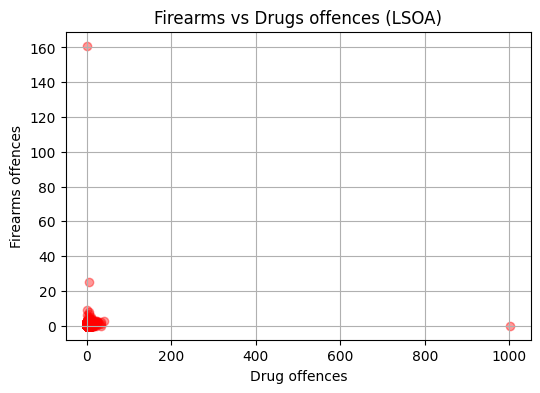

In [21]:
# Firearms vs Drugs scatter plot
fd_plot = Firearms_Drug.toPandas()
plt.figure(figsize=(6,4))
plt.scatter(fd_plot["Drugs"], fd_plot["Firearms"], color="red", alpha = 0.4)
plt.title("Firearms vs Drugs offences (LSOA)")
plt.xlabel("Drug offences")
plt.ylabel("Firearms offences")
plt.grid(True)
plt.show()

**conclusion:** There is no close association between firearms and drug offences. Both the scatter plot and the near-zero correlation coefficient (0.002) show that firearm incidents are not strongly linked to drug-related crime at LSOA level. Therefore the claim is false.

#**Design, Development and Reasoning Behind Visualizations**

Three visualization types were selected to support the analytical claims and guide subsequent statistical analysis. Visualisation plays a critical role in exploratory data analysis by transforming large, complex datasets into interpretable patterns that can inform hypothesis testing and model selection. The chosen visualisations were designed to align directly with the three claims under investigation: temporal change, regional comparison, and association between crime types.

**Line Chart: Burglary Trend**

A line chart displaying burglary counts over time was selected to examine whether burglary crime is continuously increasing. Line charts are particularly well suited to time series data because they clearly display direction, rate of change, and structural shifts across time (Kirk, 2021). This design choice enables rapid identification of long-term trends while smoothing short-term fluctuations that may obscure broader patterns.
If burglary were continuously increasing, the expected visual pattern would be a consistent upward trajectory across years. Instead, the line chart revealed an initial rise followed by a sustained decline. This visual evidence challenged the documentary claim and justified the application of regression analysis to formally quantify the trend. Thus, the line chart served both an explanatory and diagnostic role, motivating further statistical testing rather than acting as evidence in isolation.

**Bar Chart: Firearms Per Capita Comparison**

A bar chart was used to compare firearm incidents per capita in Liverpool against other UK regions. Bar charts are effective for comparing magnitudes across discrete categories because differences in height are easily perceived and interpreted (Wickham, 2022). This makes them particularly suitable for policy-relevant comparisons between geographic areas.
Crucially, firearm incidents were normalised by population to avoid misleading conclusions based on raw counts. Without per-capita adjustment, larger populations would appear to have higher crime simply due to scale. The bar chart design clearly highlights relative differences in risk rather than absolute volume, supporting fair comparison between regions. This visualisation therefore directly supports the assessment of whether Liverpool experiences disproportionately high firearm incidents per head compared to elsewhere in the UK.


**Scatter Plot: Firearms vs Drugs**

A scatter plot was selected to explore the potential association between firearm incidents and drug offences at the LSOA level. Scatter plots are well suited to examining relationships between two continuous variables and identifying patterns such as clustering, dispersion, or outliers (Knaflic, 2024).
The expected pattern for a strong association would be a clear upward trend, where higher drug offence counts correspond to higher firearm incidents. Instead, the scatter plot showed a widely dispersed distribution with no obvious linear pattern. This visual finding supported the subsequent correlation analysis, which indicated a weak relationship. The scatter plot therefore functioned as an exploratory tool that contextualised and validated the statistical results.

Collectively, the three visualisations support complementary analytical goals: trend detection (line chart), comparative assessment (bar chart), and relationship exploration (scatter plot). Each was deliberately chosen to match the structure of the data and the nature of the claim being tested. Together, they provide intuitive, transparent evidence that guides statistical modelling and supports data-driven decision making, while avoiding over-reliance on any single visual or metric.


#**Statistical Analysis and Evaluation Measures using linear regression (Burglary):**

To determine whether burglary crime is increasing over time, a statistical trend analysis is required rather than relying on visual inspection alone. Linear regression is a common method for evaluating trends in time series data because it provides a slope indicating direction and rate of change (James et al., 2013). In this case, burglary counts are modelled as a function of year.

To evaluate model performance, multiple metrics are required. R² measures how much variance in burglary counts is explained by time (Stock and Watson, 2019). RMSE (Root Mean Squared Error) measures the average magnitude of prediction errors, giving more weight to larger errors (Hyndman and Athanasopoulos, 2021).

MAE (Mean Absolute Error) provides the average absolute prediction error, which is more robust to outliers. Using multiple evaluation measures ensures that the trend is not only directionally correct but also statistically reliable.
The code below fits a linear regression model using Spark MLlib and reports slope, R², RMSE, and MAE.

In [22]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Ensure Year is numeric
Burglary_trend = Burglary_trend.withColumn("Year", col("Year").cast("int"))

# Assemble features
assembler = VectorAssembler(inputCols=["Year"], outputCol="features")
data = assembler.transform(Burglary_trend).select("features", "count")

# Train linear regression
lr = LinearRegression(featuresCol="features", labelCol="count")
model = lr.fit(data)

print("Slope:", model.coefficients[0])
print("R2:", model.summary.r2)
print("RMSE:", model.summary.rootMeanSquaredError)
print("MAE:", model.summary.meanAbsoluteError)

Slope: -72.86013985989545
R2: 0.031282296647311414
RMSE: 1399.6411405983035
MAE: 1065.1048951050736


#**Interpretation of Results:**

The linear regression slope is −72.86, indicating that burglary incidents decrease by approximately 73 crimes per year on average. This provides statistical evidence that burglary is not continuously increasing.

However, the R² value is 0.031, meaning that only 3.1% of the variation in burglary counts is explained by time alone. This indicates that although the overall trend is downward, year is a weak explanatory variable, and other factors such as policing strategies, socio-economic conditions, and reporting behaviour are likely to influence burglary rates.

The RMSE (1,399.64) and MAE (1,065.10) values are large, indicating substantial prediction error. This confirms that a simple linear trend model is not suitable for accurate prediction and is better suited for identifying general direction rather than precise forecasting.

### **Conclusion**
The statistical analysis shows a negative trend, so the claim that burglary is continuously increasing is false. However, the low R² and high error metrics suggest the trend is weak and influenced by other factors. Thus, the model is useful for detecting direction but not for precise prediction.


#**Critical Discussion on the Advantages, Disadvantages and Limitations of Analytical Methods**

Large-scale crime datasets require analytical methods that manage volume, complexity, and noise. This study applied five core methods: filtering, aggregation, regression, correlation, and per-capita comparison. Each method contributes differently to addressing the research objectives but introduces assumptions and limitations that affect interpretation. A critical discussion is therefore necessary to assess their suitability and impact on validity and reliability, particularly when drawing conclusions for policy or risk assessment.

#**1. Filtering**

Filtering selects relevant observations from a dataset to focus analysis on specific crime types. In this study, filtering retained burglary, possession of weapons, and drug offences. Filtering improves computational efficiency by reducing very large datasets to manageable sizes, enabling faster aggregation and statistical analysis (Rahm and Do, 2000). It also improves clarity by removing irrelevant categories, ensuring results address the claims directly. However, filtering risks loss of context, as crime types are interconnected; excluding related offences such as theft or violence may obscure relationships influencing burglary trends (Wilson and Martinez, 2000). Filtering also depends on accurate classification, meaning mislabelled records can introduce bias. The main limitations are selection bias and reduced generalisability: findings cannot be extended to overall crime patterns, and missing data may not be random, potentially biasing results (Rahm and Do, 2000).

#**2. Aggregation**

Aggregation summarises detailed records into higher-level measures such as annual or regional totals. In this analysis, aggregation calculated yearly burglary trends and regional firearm counts. Aggregation simplifies complex data and reduces short-term noise, making long-term trends clearer (Alteryx, 2025). It also reduces data volume, improving efficiency and enabling comparisons across time and regions. Despite these benefits, aggregation can mask important detail. Annual aggregation removes seasonal patterns and can oversimplify variability, potentially misleading interpretation. A key limitation is ecological fallacy, where relationships at aggregated levels do not apply locally. Aggregation assumes homogeneity within regions, despite variation between neighbourhoods, and reduces observations, limiting statistical power (Chaudhuri et al., 2016).

#**3. Regression**

Regression was used to examine burglary trends over time, with linear regression estimating annual change. Regression is interpretable and widely used for trend detection, producing a clear slope indicating direction (James et al., 2013). Evaluation metrics such as R², RMSE, and MAE allow assessment of model fit and predictive accuracy. However, linear regression assumes linearity, which may not reflect real crime dynamics influenced by policy changes or economic shocks. This limitation is reflected in the low R², showing time explains only a small proportion of variation. Regression also assumes independence, often violated in time-series data due to autocorrelation (Wooldridge, 2016). Regression is further limited by variable omission: using year alone ignores socioeconomic conditions and policing strategies, and regression identifies association rather than causation.


#**4. Correlation**
Correlation analysis examined the association between firearm incidents and drug offences using Pearson correlation. Correlation offers a simple measure of linear association and, alongside scatter plots, supports rapid exploratory analysis. The near-zero correlation suggests no strong relationship at the LSOA level. However, correlation does not imply causation and only captures linear relationships. Pearson correlation is sensitive to outliers and skewed distributions common in crime data with many zero counts. It is also limited by aggregation and sparsity; low counts reduce reliability and confounding variables are ignored, so correlations may miss underlying causal links.

#**5. Per-capita Comparison**

Per-capita comparison normalises crime counts by population to enable fair regional comparison. This method compared firearm incidents per head in Liverpool with other UK regions. Per-capita rates correct for population bias and provide a meaningful measure of relative risk, supporting fair comparison and resource allocation (Rao, 2018). However, per-capita rates can exaggerate risk in small populations, where a few incidents produce high rates. Population estimates may also be outdated or misaligned with crime data. Limitations include the assumption that population size is the main determinant of crime, ignoring socioeconomic, cultural, and policing factors, and assuming uniform exposure within populations.

#**Conclusion**

The five analytical methods provide complementary insights but introduce limitations. Filtering and aggregation improve efficiency but reduce context and granularity. Regression quantifies trends but relies on restrictive assumptions and limited variables. Correlation supports exploratory analysis but cannot establish causality. Per-capita comparison enables fair comparisons but may misrepresent risk in small areas. Overall, these methods are suitable for exploratory analysis and claim testing, but findings should be interpreted cautiously. Future research should include additional explanatory variables and advanced models to improve robustness and ensure more comprehensive, evidence-based conclusions.

#**Evaluation and Conclusion**

This project evaluated three claims using the full UK crime dataset processed in Apache Spark. The aim was to test whether burglary is increasing, whether Liverpool has the highest firearms incidents per head, and whether firearms crimes are linked to drugs.

The results show that burglary is not continuously increasing; instead, it has declined over time. The regression trend is negative, though the low R² suggests other factors influence burglary rates. The claim that Liverpool has the highest firearms incidents per capita is false, as other UK areas show higher per-capita rates. Finally, firearms and drug offences show no strong association, with a near-zero correlation.

#**Insurance advice**

Risk assessment should rely on data-driven per-capita measures and local factors rather than national claims. Insurers should use dynamic models incorporating socio-economic and regional variables to better estimate crime risk.



#**REFERENCES:**
Alteryx (2025) *What is data aggregation?* Alteryx. Available at: https://www.alteryx.com/glossary/data-aggregation (Accessed: 2 January 2026).

Chaudhuri, S., Motwani, R. and Narasayya, V. (2016) *Overcoming limitations of sampling for aggregation queries.* Microsoft Research. Available at: https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/icde01.pdf (Accessed: 8 January 2026).

Dean, J. and Ghemawat, S. (2008) *MapReduce: Simplified data processing on large clusters.* Communications of the ACM, 51(1), pp.107–113. Available at: https://dl.acm.org/doi/epdf/10.1145/1327452.1327492 (Accessed: 20 January 2026).

Eck, J.E., Chainey, S., Cameron, J.G., Leitner, M. and Wilson, R.E. (2005) *Mapping crime: Understanding hot spots.* National Institute of Justice Research Report. Available at: https://www.ojp.gov/pdffiles1/nij/209393.pdf (Accessed: 20 January 2026).

Hyndman, R.J. and Athanasopoulos, G. (2021) *Forecasting: Principles and Practice.* 3rd edn. OTexts. Available at: https://otexts.com/fpp3/basic-steps.html (Accessed: 21 January 2026).

James, G., Witten, D., Hastie, T. and Tibshirani, R. (2013) *An Introduction to statistical learning.* 1st edn. New York: Springer. Available at: https://www.stat.berkeley.edu/~rabbee/s154/ISLR_First_Printing.pdf (Accessed: 18 January 2026).

Kirk, A. (2021) *Data Visualisation: A Handbook for Data Driven Design*. 2nd edn. London: Sage.  Available at: http://103.203.175.90:81/fdScript/RootOfEBooks/E%20Book%20Collection%20-%202021/CSE/Data_Visualisation_A_Handbook_For_Data_Driven_Design_by_Andy_Kirk.pdf (Accessed: 20 December 2026).

Knaflic, C.N. (2024) *Storytelling with Data: A Data Visualization Guide for Business Professionals*. 2nd edn. Hoboken, NJ: Wiley.  Available at: https://luutruvn.com/wp-content/uploads/2025/03/Storytelling-with-Data_-A-Data-Visualization-Guide-for-Business-Professionals-PDFDrive-.pdf (Accessed: 21 December 2026).

Rahm, E. and Do, H. H. (2000) *'Data cleaning: Problems and current approaches',* IEEE Bulletin of the Technical Committee on Data Engineering, 23(4). Available at: https://dbs.uni-leipzig.de/files/research/publications/2000-1/pdf/TBDE2000.pdf (Accessed: 1 January 2026).

Rao, C. R. (2018) *Linear Statistical inference and Its applications.* 2nd edn. New York: Wiley. Available at: https://ia801508.us.archive.org/25/items/in.ernet.dli.2015.40834/2015.40834.Linear-Statistical-Inference-And-Its-Applications.pdf (Accessed: 5 January 2026).

Wickham, H. (2022) *ggplot2: Elegant Graphics for Data Analysis*. 2nd edn. New York, NY: Springer.  Available at: https://scispace.com/pdf/ggplot2-elegant-graphics-for-data-analysis-102a7agfxj.pdf (Accessed: 20 December 2026).

Wilson, D. R. and Martinez, T. R. (2000) *‘Reduction techniques for instance-based learning algorithms’,* Machine Learning, 38(3), pp. 257–286. Available at: https://www.researchgate.net/publication/226428802_Reduction_Techniques_for_Instance-Based_Learning_Algorithms (Accessed: 8 January 2026).

Wooldridge, J.M. (2016) *Introductory Econometrics: A modern approach*. 6th edn. Boston: Cengage Learning. Available at: https://www.sea-stat.com/wp-content/uploads/2020/08/James-H.-Stock-Mark-W.-Watson-Introduction-to-Econometrics-Global-Edition-Pearson-Education-Limited-2020.pdf (Accessed: 20 January 2026).
